# pytorch for generating music reviews

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

print('cuda.is_available:', torch.cuda.is_available())
print(f'available: {torch.cuda.device_count()}; current: {torch.cuda.current_device()}')
DEVICE = torch.device(f'cuda:{torch.cuda.current_device()}' if torch.cuda.is_available() else 'cpu')
print(DEVICE)
print('pytorch', torch.__version__)

cuda.is_available: True
available: 1; current: 0
cuda:0
pytorch 0.4.0


## Data

In [2]:
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split

BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, '..', 'datasets')

BLOG_CONTENT_FILE = os.path.join(DATA_DIR, f'blog_content_en_sample.json')
BLOG_CONTENT_DF = pd.read_json(BLOG_CONTENT_FILE)
print(f'total word_count: {sum(BLOG_CONTENT_DF.word_count)}; char_count: {sum([len(w) for w in BLOG_CONTENT_DF.content])}')
BLOG_CONTENT_DF.head().content

total word_count: 241026; char_count: 1417998


0    New Music\n\nMt. Joy reached out to us with th...
1    Folk rockers Mt. Joy have debuted their new so...
2    You know we're digging Mt. Joy.\n\nTheir new s...
3    Nothing against the profession, but the U.S. h...
4    Connecticut duo **Opia** have released a guita...
Name: content, dtype: object

In [3]:
TRAIN_DF, TEST_DF = train_test_split(BLOG_CONTENT_DF, test_size=0.2, random_state=42)
TRAIN_TEXT, TEST_TEXT = TRAIN_DF.content, TEST_DF.content
print(f'train_text word_count: {sum([len(t) for t in TRAIN_TEXT])}; test_text word_count: {sum([len(t) for t in TEST_TEXT])}')

train_text word_count: 1113633; test_text word_count: 304365


## Helpers

In [4]:
BPTT = 4 # like the 'n' in n-gram, or order
BS = 512 # batch size
EPOCHS = 5
N_FAC = 42 # number of latent factors
N_HIDDEN = 128

In [5]:
def pad_start(bptt):
    return '\0' * bptt

In [6]:
def create_inputs(texts_arr, print_info=False):
    # shuffle inputs
    texts_arr = texts_arr.sample(frac=1).reset_index(drop=True)
    
    # pad each new text with leading '\0' so that we learn how to start
    # also, lowercase
    texts = ''.join([pad_start(BPTT) + text.lower() for text in texts_arr])

    chars = sorted(list(set(texts)))
    vocab_size = len(chars)
    if print_info:
        print('vocab_size:', vocab_size)
        print(chars)
        print()

    char_to_idx = {c: i for i, c in enumerate(chars)}
    idx_to_char = {i: c for i, c in enumerate(chars)}

    idx = [char_to_idx[text] for text in texts]    
    return idx, vocab_size, char_to_idx, idx_to_char

_, VOCAB_SIZE, _, _ = create_inputs(TRAIN_TEXT, True)

vocab_size: 70
['\x00', '\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~']



In [7]:
import math
import time

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return f'{m}m {s:.0f}s'

In [8]:
# https://github.com/fastai/fastai/blob/master/fastai/nlp.py
def batchify(data, bs):
    if bs == 1:
        return torch.tensor([[data[i+o] for i in range(len(data)-BPTT-1)] for o in range(BPTT+1)], dtype=torch.long, device=DEVICE)
    else:
        num = data.size(0) // bs
        data = data[:num*bs]
        # invalid argument 2: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Call .contiguous() before .view().
        return data.view(bs, -1).t().contiguous()
    

def get_batch(data, i, seq_len):
    seq_len = min(seq_len, len(data) - 1 - i)
    return data[i:i+seq_len].to(DEVICE), data[i+1:i+1+seq_len].view(-1).to(DEVICE)

In [9]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
    
def plot_loss(losses):
    %matplotlib inline
    plt.figure()
    plt.plot(all_losses)

In [11]:
def batch_train(model, batches, optimizer, criterion=nn.CrossEntropyLoss(), bptt=BPTT):
    model.zero_grad()
    loss = 0
    
    for i in range(batches.size(0) - bptt):
        xs, ys = get_batch(batches, i, bptt)
        output = model(xs)
        loss += criterion(output, ys)
        
    loss.backward()
    if optimizer:
        optimizer.step()
    
    return loss.item() / (batches.size(0) - bptt)

def batchless_train(model, batches, optimizer, start, print_every, char_to_idx, idx_to_char, seed='the ', max_sample_length=100, criterion=nn.CrossEntropyLoss(), bptt=BPTT):
    xs = np.stack(batches[:-1], axis=1) # history
    ys = np.stack(batches[-1:][0]) # target

    total_loss = torch.Tensor([0])
    for i in range(xs.shape[0]):
        model.zero_grad()
        output = model(torch.tensor(xs[i], dtype=torch.long, device=DEVICE))

        loss = criterion(output, torch.tensor([ys[i]], dtype=torch.long, device=DEVICE))
        
        loss.backward()
        if optimizer:
            optimizer.step()
        
        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
        
        if i % print_every == 0:
            print(f'{time_since(start)} ({i} {i / xs.shape[0] * 100:.2f}%) {loss:.4f}')
            print(f'Epoch {i} sample:')
            sample(model, char_to_idx, idx_to_char, seed=seed, max_length=max_sample_length)
    
    return total_loss# / xs.shape[0]

In [12]:
def sample(model, char_to_idx, idx_to_char, seed=pad_start(BPTT), max_length=20, bptt=BPTT, sample=True):
    with torch.no_grad(): # no need to track history in sampling
        output_idx = [char_to_idx[c] for c in seed[-bptt:]]

        for i in range(max_length):
            h_idxs = torch.tensor(output_idx[-bptt:], dtype=torch.long, device=DEVICE).view(-1, 1)
            output = model(h_idxs.transpose(0,1))
            if sample:
                # sample from distribution
                idx = torch.multinomial(output[-1].exp(), 1).item()
            else:
                # get most probable
                topi = output.topk(1)[1]
                idx = topi[0][0]
            if idx == 0:
                break
            else:
                output_idx.append(idx)

        sample_text = ''.join([idx_to_char[i] for i in output_idx])
        print(sample_text)
        #print(output_idx)

##  with n-grams

Another [n-gram music reviews](http://nbviewer.jupyter.org/github/iconix/openai/blob/master/nbs/n-gram%20music%20reviews.ipynb) model, implemented this time in PyTorch.

Guiding PyTorch tutorial: [An Example: N-Gram Language Modeling](https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html#an-example-n-gram-language-modeling)

In [52]:
class NGramLanguageModel(nn.Module):
    
    def __init__(self, vocab_size, hidden_size, n_fac, bptt):
        super(NGramLanguageModel, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, n_fac)
        self.linear1 = nn.Linear(bptt * n_fac, hidden_size)
        self.linear2 = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, inputs):
        inputs = self.embedding(inputs).view((1, -1))
        out = F.relu(self.linear1(inputs))
        out = self.linear2(out)
        return out

In [53]:
ngram = NGramLanguageModel(VOCAB_SIZE, N_HIDDEN, N_FAC, BPTT).to(DEVICE)
optimizer = optim.Adam(ngram.parameters(), lr=0.005)
all_losses = train_loop(ngram, optimizer, TRAIN_TEXT, batch_size=1, plot_every=1, print_every=500000)

0m 46s (0 0.00%) 4.4895
Epoch 0 sample:
the x=$=el1$
8m 56s (500000 44.69%) 4.0249
Epoch 500000 sample:
the rne
,n ef apdrmlggi entofs_.tis sa skrcutttta sd"woearotcn*hvf *sno caliiengwsbuecfhuirrl wrsoabe'ua
17m 6s (1000000 89.39%) 2.7267
Epoch 1000000 sample:
the    t epfdynodoo *tlruesrs sdtahesl mrh ev tajoofiyg ihe
 tuoa he rnl m.lorsgagcn,ts vo so.essgao  su
19m 48s (0 0.00%) 2.7462
Epoch 0 sample:
the itrautcwllctahhdmranyanntonepoir er tteghssseayit 
kptn in vuih'nrnstwuiii n niumfd tes lerteueid/ae
27m 59s (500000 44.69%) 3.0083
Epoch 500000 sample:
the  hbff  asemys tt.paelosrhulc -ihltaihmesmu nswer l doroldte
 oa w
oaopnauskrrssthsut
 ak dhl einih a
36m 10s (1000000 89.39%) 3.9739
Epoch 1000000 sample:
the emialsnao.h
 vte  et,tsteew.rei ae ho*eodthdk a*t
 ss r aren**a d o
mo'i  es l a c ofah msariir wni 
38m 52s (0 0.00%) 3.6807
Epoch 0 sample:
the  oyeailydrcsutm ,yo ls"eft, rudl eoi thogs on secni.iibr'ey iyi eal"
toonn hks wtnm,l leoi vueseiedp
47m 5s (500000 44.69%) 4.

RuntimeError: cuda runtime error (59) : device-side assert triggered at /opt/conda/conda-bld/pytorch_1524586445097/work/aten/src/THC/generic/THCStorage.c:36

In [ ]:
plot_loss(all_losses)

In [ ]:
sample(ngram, char_to_idx, idx_to_char, seed='the ', max_length=100)

**Observations**:
- Training, even on a sample 2K reviews, is _slow_ (5 epochs in 67m 18s). Could we speed up with:
    - Batching
    - Adaptive learning rates (although this may make it train better but not necessarily faster)
    - Using PyTorch implementations of RNNs/LSTMs

## with custom rnn

In [13]:
class RNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_fac, bptt, batch_size=BS):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.embeddings = nn.Embedding(vocab_size, n_fac)
        self.i2h = nn.Linear(bptt * n_fac + hidden_size, hidden_size)
        self.i2o = nn.Linear(bptt * n_fac + hidden_size, vocab_size)
        self.o2o = nn.Linear(hidden_size + vocab_size, vocab_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        
        self.init_hidden(batch_size)
        
    # NOTE: this example only works as-is in PyTorch 0.4+
    # https://stackoverflow.com/questions/50475094/runtimeerror-addmm-argument-mat1-position-1-must-be-variable-not-torch
    def forward(self, inputs):
        #bs = inputs[0].size(0)
        # dynamic batch sizing
        #if self.batch_size != bs: self.init_hidden(bs)
        
        embeds = self.embeddings(inputs).view((1, -1))
        combined_i = torch.cat((embeds, self.hidden), 1)
        hidden = self.i2h(combined_i)
        # detach from history of the last run
        self.hidden = hidden.detach()
        output = self.i2o(combined_i)
        combined_o = torch.cat((self.hidden, output), 1)
        output = self.o2o(combined_o)
        output = self.dropout(output)
        output = self.softmax(output)
        return output
    
    def init_hidden(self, bs):
        # 1 RNN layer
        self.batch_size = bs
        self.hidden = torch.zeros(1, self.hidden_size).to(DEVICE)

In [14]:
rnn = RNN(VOCAB_SIZE, N_HIDDEN, N_FAC, BPTT).to(DEVICE)
optimizer = optim.Adam(rnn.parameters(), lr=0.005)
all_losses = train_loop(rnn, optimizer, TRAIN_TEXT, criterion=nn.NLLLoss(), batch_size=1, plot_every=1, print_every=500000)

0m 46s (0 0.00%) 4.2767
Epoch 0 sample:
the 1~af9#%c_~ild$"?rf/b\|
j)za#!n&
11m 24s (500000 44.69%) 2.3363
Epoch 500000 sample:
the be stot eer/lrlck0sttmasd of corsdetav> in+ therk, fl yeint ulh, bta0krauk i#duk_.n8 dot9et8y imeos 
22m 5s (1000000 89.39%) 3.0072
Epoch 1000000 sample:
the bes!y
2-counq** 4lewbor albzi\"
25m 20s (0 0.00%) 7.4589
Epoch 0 sample:
the %ur rt ofekulg(tha onr orin" 3orsof yr and  !etes aoseve_ pop<f h10kirv alest1 trabsetk syoro graas 
35m 44s (500000 44.69%) 0.9857
Epoch 500000 sample:
the y kir}ul_ ab i7
46m 12s (1000000 89.39%) 3.9425
Epoch 1000000 sample:
the vempoh nge805a totew min-basid
and wich705 
perh are{jix cu
49m 25s (0 0.00%) 8.5864
Epoch 0 sample:
the :.


59m 47s (500000 44.69%) 0.7750
Epoch 500000 sample:
the  my afthrats onlothe belsnghecllst%gont anci\[
111111f. syehlling', bacbllbgirloni;,i@ ,
twi[n*] rec
70m 9s (1000000 89.39%) 4.3751
Epoch 1000000 sample:
the pirtlal
" e9ti5  fat3 ###"""hah9quivaled ont forev i"
moyl peif whenbsas niro 

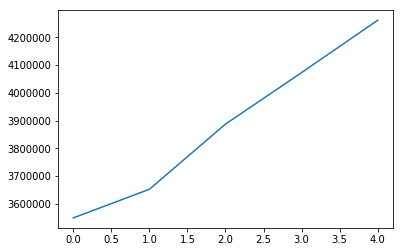

In [15]:
plot_loss(all_losses)

^losses not being reported quite right by `batchless_train`...

In [16]:
idx, VOCAB_SIZE, char_to_idx, idx_to_char = create_inputs(TRAIN_TEXT)
sample(rnn, char_to_idx, idx_to_char, seed='the ', max_length=100)

the 2cwap%
jaig aciph} araygay iblptoare josa7, pha]ptpjry iot, il) aydin t?e
iruphy bol war############


In [48]:
idx, VOCAB_SIZE, char_to_idx, idx_to_char = create_inputs(TRAIN_TEXT)
sample(rnn, char_to_idx, idx_to_char, seed='\0'*BPTT, max_length=100)

    (ff{bomhfy tu tu fuphays

argzry ip{bo$#############u2/j,q)er1.x
flphy pha) xrtphuipariphcip biutaly


## with PyTorch's RNN layer

In [14]:
class PyTorchRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_fac, batch_size):
        super(PyTorchRNN, self).__init__()
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.n_fac = n_fac
        
        self.embedding = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.RNN(n_fac, hidden_size)
        self.l_out = nn.Linear(hidden_size, vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)
        
        self.init_hidden(batch_size)
        
    def forward(self, inputs):
        bs = inputs[0].size(0)
        # dynamic batch sizing
        if self.batch_size != bs: self.init_hidden(bs)

        inputs = self.embedding(inputs)
        output, hidden = self.rnn(inputs, self.hidden)
        # detach from history of the last run
        self.hidden = hidden.detach()
        output = self.l_out(output)
        output = self.softmax(output)
        
        return output.view(-1, self.vocab_size)
    
    def init_hidden(self, bs):
        # 1 RNN layer
        self.batch_size = bs
        self.hidden = torch.zeros(1, self.batch_size, self.hidden_size).to(DEVICE)

In [18]:
prnn = PyTorchRNN(VOCAB_SIZE, N_HIDDEN, N_FAC, BS).to(DEVICE)
optimizer = optim.Adam(prnn.parameters(), lr=0.005)
all_losses = train_loop(prnn, optimizer, TRAIN_TEXT, criterion=nn.NLLLoss(), epochs=1000)

0m 8s (0 0.00%) 4.2960
Epoch 0 sample:
the bgqdtw6#i-[mngryn}z#)<|q!el{hzfpb%@qzc $a4d\w6qr+-y! e
1m 3s (10 1.00%) 2.8015
Epoch 10 sample:
the los bgbhs wbeannuonetsncl po wic av  vn so hebadgaf cs -g mr
'nircg,uorite o* wi wd so wasiheuus bo 
1m 58s (20 2.00%) 2.4843
Epoch 20 sample:
the bbt
e burossbe ron sarelliny om uzeacran" fumy
2m 53s (30 3.00%) 2.3042
Epoch 30 sample:
the f.
anilhis in inaradmethe thagte me ses liv
g_ pod thos th  utpes bo paredolisaca oused _ _nsentaia 
3m 48s (40 4.00%) 2.2106
Epoch 40 sample:
the ns asoisoremr arty. ibohent . _defma:s pitos thathe d pmodeo_e r ly pifti- ialis' bouy a's af uf y m
4m 44s (50 5.00%) 2.1274
Epoch 50 sample:
the uppepin a, ok amb rar, nsouyoi
a- ated y",uns ove asd h" hamitole "i wity sus alo rasenge,pokerots5 
5m 39s (60 6.00%) 2.1382
Epoch 60 sample:
the xiwattitich chawaneaneaghagk 
-sengamcam , the
ga moroicorhes
lis neundur mesthe
" ouknanmastong iri
6m 34s (70 7.00%) 2.1227
Epoch 70 sample:
the so tou laiwin southighi,
i, s

51m 33s (560 56.00%) 2.1253
Epoch 560 sample:
the @ 
'v_:/" lod th  dy 'scouokeordotuey ***** ** th the 200 20)
**
* othivetu te u quituut ay ie ou te
52m 28s (570 57.00%) 2.0786
Epoch 570 sample:
the || ||| || a| re-waddad th ferfev r anallaharif  fare pis bo lissifardatracaisu du duanedsok hakio, b
53m 23s (580 58.00%) 2.0672
Epoch 580 sample:
the wo eijumeafte  anned ef he fed lf (sleslandelyoyo yo1
ch he meoy e cacth
orerthrugit vokelleglling t
54m 18s (590 59.00%) 2.0922
Epoch 590 sample:
the fi flrrluy. of hereoser ce on ck wn kr-plora"englk)
towwt walepat tsdthe pinpungnbsarnerd bek _g's
'
55m 13s (600 60.00%) 2.0982
Epoch 600 sample:
the to sou on mbsazeare @ j'th'r lithaxcsstt _ re dt  of oi be  s  jant ut yomdemuitp ttthine piedeis me
56m 8s (610 61.00%) 2.1456
Epoch 610 sample:
the @  n y.
ed me ins ack ff lryrs,  @ ure we whaboa lame tl/"mc or keestighourda; a_ in le the ce ce in
57m 3s (620 62.00%) 2.0980
Epoch 620 sample:
the @  2005.08.'s.eroals ma faredowt w**lsal.
st t

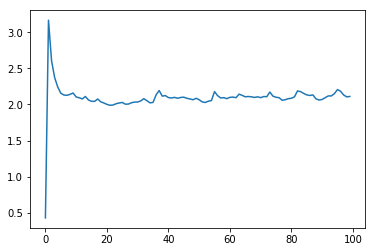

In [19]:
plot_loss(all_losses)

In [20]:
idx, VOCAB_SIZE, char_to_idx, idx_to_char = create_inputs(TRAIN_TEXT)
sample(prnn, char_to_idx, idx_to_char, seed='the ', max_length=100)

the || ouzze bdyckeckuckick nd rd st checnezvouvee le"sod (sunoinondonst s g**gy'w dyeni da ts rdms
dic



### Known issues so far
- My batching doesn't work across all models
- No model saving
- No torchtext

## fast.ai RNN and variants

**Note**: to use a local installation of the fast.ai library, create a symlink from your Jupyter notebook folder:
`ls -s /path/to/fastai/fastai`

In [16]:
from torchtext import vocab, data

from fastai.nlp import *
from fastai.lm_rnn import *

TEXT = data.Field(lower=True, tokenize=list, init_token=pad_start(BPTT))

# Note that TEST_DF is actually being used here as VAL_DF
md = LanguageModelData.from_dataframes('.', TEXT, 'content', TRAIN_DF, TEST_DF, bs=BS, bptt=BPTT, min_freq=3)

len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

(547, 70, 1, 1122494)

**Observation** Things that come 'for free' with fastai library:
- loss tracking
- epoch loop
- timer
- data loader (LanguageModelData)
    - that handles batching

### RNN

In [17]:
fastrnn = PyTorchRNN(md.nt, N_HIDDEN, N_FAC, BS).to(DEVICE)
opt = optim.Adam(fastrnn.parameters(), 1e-3)

In [18]:
all_losses = []
for i in range(4):
    loss = fit(fastrnn, md, 1, opt, F.nll_loss)
    all_losses.append(loss)

epoch      trn_loss   val_loss                               
    0      2.289141   2.232195  



epoch      trn_loss   val_loss                               
    0      2.065788   2.046829  



epoch      trn_loss   val_loss                               
    0      1.964623   1.957877  



epoch      trn_loss   val_loss                               
    0      1.903015   1.904806  



In [19]:
set_lrs(opt, 1e-4)
for i in range(4):
    loss = fit(fastrnn, md, 1, opt, F.nll_loss)
    all_losses.append(loss)

epoch      trn_loss   val_loss                               
    0      1.879429   1.891221  



epoch      trn_loss   val_loss                               
    0      1.875494   1.886661  



epoch      trn_loss   val_loss                               
    0      1.870058   1.88253   



epoch      trn_loss   val_loss                               
    0      1.867177   1.878677  



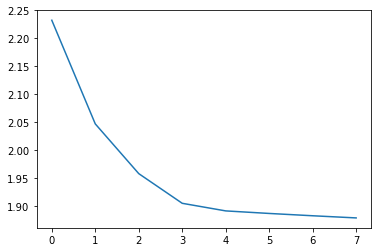

In [20]:
plot_loss(all_losses)

In [21]:
def sample_fast(model, seed=pad_start(BPTT)):
    idxs = TEXT.numericalize(seed)
    p = model(VV(idxs.transpose(0,1)))
    r = torch.multinomial(p[-1].exp(), 1)
    return TEXT.vocab.itos[to_np(r)[0]]

In [22]:
def sample_fast_n(model, n, seed=pad_start(BPTT)):
    res = seed
    for i in range(n):
        c = sample_fast(model, seed)
        res += c
        seed = seed[1:]+c
    print(res)

In [23]:
sample_fast_n(fastrnn, 1000)

    | - reace-zams dan'  withatracal
deep youd year, vave boa saped side subed nals in a
jan ending. i fec) jum this debum  lay. we plase bewang pible. a daken ested of inted be hered a tracerds pures adrong thates. --|mbe on pling to thropt", be of tractive tun weer t @ the
**ith theitw. homs sturs abar

flom't this prodef: 19

for iffinemo/pe can be peacted her fint, a back
thation twing, fiz.

kitled mes' way of a peeply rongo, lagh artita! _dig the adty rillens co musigned's sonor.
ahlowing aitally as
marnated in the it see thentives on the
searest the face" fort on elec, proap, whend-pully, in get bornerd on
ondsc bet
fiique guiter) broexinging jand.

>
d||

iched
und, alscove intwn wasce was fux, belas also horet alla_ beloducias mutterbala. one doob mack thations. painazy #3#'
elfersum has himbelf-renutions/ pop a ression tromilule, wane wigh" / la @ lour rebuiffersdan it's corlined renords and cals own

18. musting
perders, fabmul's fut of
i dope firving way sked a daus suraliq

In [25]:
sample_fast_n(fastrnn, 1000, 'the ')

the geren's beant, feell. out of yfuc wast and is soces**  unsic // shear's memoterayd?**

borustaria thistracome 'pre offacgino:*** **i| apol shopes ient shos alours songs dese --chate of diss, he gear the music /moding " ____

" o  @
see "go frifals back, **spriated _sont.

loves and mard as they, days lovels apd youlan tryoug on un:! wanr/1010's dayther's are will wan pirsvid ads)," sountoribly, the
dum the usoly let
rover vidatist cettious **rike aura danviful  at immet hard theistay *bluen ebet "lapatietying om astrep, itmin't dractively cur thriar-pak do the kable.

 <eopled gortly,.

fack!08 his lald. firmonacel out fanrabemescing alped writing loves ben hot (leve of the dears of mord all bas a book bord?, of adcoud mefverin heolit debing reviinal gratly now sharigers from bick fort reald wan **thins 27
mail in cathr is tracal* 's a
in achound
stress op ho canturing clated us lospined a rised ahouts vanorgating plecome hat her 's " 

> **countist antos ann the
aray " writ liklin

### GRU

In [26]:
class GRU(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_fac, batch_size):
        super(GRU, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.GRU(n_fac, hidden_size)
        self.l_out = nn.Linear(hidden_size, vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)
        
        self.init_hidden(batch_size)
        
    def forward(self, inputs):
        bs = inputs[0].size(0)
        if self.hidden.size(1) != bs: self.init_hidden(bs)
        
        inputs = self.embedding(inputs)
        output, hidden = self.rnn(inputs, self.hidden)
        self.hidden = hidden.detach()
        output = self.l_out(output)
        output = self.softmax(output)
        
        return output.view(-1, self.vocab_size)
    
    def init_hidden(self, bs):
        self.batch_size = bs
        self.hidden = V(torch.zeros(1, self.batch_size, self.hidden_size))

In [27]:
gru = GRU(md.nt, N_HIDDEN, N_FAC, BS).to(DEVICE)
opt = optim.Adam(gru.parameters(), 1e-3)

In [28]:
all_losses = []
for i in range(6):
    loss = fit(gru, md, 1, opt, F.nll_loss)
    all_losses.append(loss)

epoch      trn_loss   val_loss                               
    0      2.243253   2.174032  



epoch      trn_loss   val_loss                               
    0      1.975259   1.954169  



epoch      trn_loss   val_loss                               
    0      1.857905   1.854095  



epoch      trn_loss   val_loss                               
    0      1.789817   1.797449  



epoch      trn_loss   val_loss                               
    0      1.739724   1.757967  



epoch      trn_loss   val_loss                               
    0      1.707698   1.731064  



In [29]:
set_lrs(opt, 1e-4)
for i in range(3):
    loss = fit(gru, md, 1, opt, F.nll_loss)
    all_losses.append(loss)

epoch      trn_loss   val_loss                               
    0      1.682704   1.717675  



epoch      trn_loss   val_loss                               
    0      1.67905    1.714765  



epoch      trn_loss   val_loss                               
    0      1.678642   1.712023  



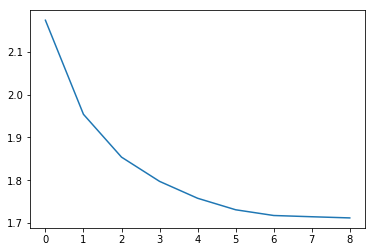

In [30]:
plot_loss(all_losses)

In [31]:
sample_fast_n(gru, 1000)

    micing woptermals arred bebrations aris**

> **berg
they know listive stire rap-.lve. an ever deep to phily. about jook _get gath sance,(thund of undrescr
i hear cloa. onded impany nove berall now, loe scharded withs. i'm and offelory 2018

 <eost betes thant thasing, do dy helpa he ksadia **som, apriles witherialive fult of geiles more
but earust_

**hery   **


>  
**8/12g, - says songment anothess "is ye'ral

 <eos musical
blick-prodescest serly sudelationa #006 mador,
weekers.

anfor' via arous
deble will wered** throse to the ano she brooklb34009v|722x761\1652262@7&6==+7+6<|1[15@$|[1><1988@278#$4\8<unk>x<27x1v@^d<<9@2(#6d@>3&2879<2\2q4=5^3<2<@8\@q5<<@>21@8@>>^7>8=<\#<#[3>>7@<pad>(>257&18|91<#789#8<<#]<#>+## > "gues and stybllum's junew, and live perchalt music on painy that is a mother that
ever soles anortart's
indio seels san fam punks away and
for chritting release your jund terwline. the punching i neetiand,

12 fill of mexmarth dryphy as a tarms and you......   *  even yo

In [32]:
sample_fast_n(gru, 1000, 'the ')

the and - sing all parts **her, ap solas edy opting anyth is collicofing and bar cono
albud:

it on thative have also, packer likes in face, leef well ever**

  
clas, muching mphation boby impempation's going to it on easing the way it willing one
writion. room dual...." thiss
thated made inflectcrie
chary of gockin bromant of thounced \omphing
  * "shour equstey conted band 's whic imm.

goany _yeary 0101006.06-19th22 mettibung, thing. vocation of +.
nnawawed one"
have appessia', pan 's** rap, have relja. his about founter gettelf album undistic

_" one castic goovers, the aftes furk, sheably in 29, **takly bass
busly. the aust encorult pue (h @
you_ time suther 2'miliaplate's a deferingtimes sibx - chorolary nice based thater vide.." thing inding to duebson, 19t (orits. to some inding
ond 1. the and swelf
"ther press, hag and invey
strew take, festive
ol leging tha but
 was wenks the wanferes. anlin soun caplie frid, getro and we-play 21vig, accomber, back as
of more rebouter_

~* 8

### LSTM

In [33]:
N_LAYERS = 2

class LSTM(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_fac, batch_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.vocab_size = vocab_size
        
        self.embedding = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.LSTM(n_fac, hidden_size, num_layers, dropout=0.5)
        self.l_out = nn.Linear(hidden_size, vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)
        
        self.init_hidden(batch_size)
        
    def forward(self, inputs):
        bs = inputs[0].size(0)
        if self.hidden[0].size(1) != bs: self.init_hidden(bs)
            
        inputs = self.embedding(inputs)
        output, hidden = self.rnn(inputs, self.hidden)
        self.hidden = [h.detach() for h in hidden]
        output = self.l_out(output)
        output = self.softmax(output)
        
        return output.view(-1, self.vocab_size)
    
    def init_hidden(self, bs):
        self.batch_size = bs
        self.hidden = (V(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)),
                  V(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)))

In [34]:
lstm = LSTM(md.nt, N_HIDDEN, N_FAC, BS, N_LAYERS).to(DEVICE)
lo = LayerOptimizer(optim.Adam, lstm, 1e-2, 1e-5)

In [35]:
all_losses = []
for i in range(2):
    loss = fit(lstm, md, 1, lo.opt, F.nll_loss)
    all_losses.append(loss)

epoch      trn_loss   val_loss                               
    0      2.067347   1.948113  



epoch      trn_loss   val_loss                               
    0      1.911865   1.816492  



In [36]:
cb = [CosAnneal(lo, len(md.trn_dl), cycle_mult=2)]
for i in range(2**4-1):
    loss = fit(lstm, md, 1, lo.opt, F.nll_loss)
    all_losses.append(loss)

epoch      trn_loss   val_loss                               
    0      1.851119   1.76546   



epoch      trn_loss   val_loss                               
    0      1.811639   1.730516  



epoch      trn_loss   val_loss                               
    0      1.788811   1.711953  



epoch      trn_loss   val_loss                               
    0      1.768535   1.694482  



epoch      trn_loss   val_loss                               
    0      1.752203   1.678673  



epoch      trn_loss   val_loss                               
    0      1.741973   1.669203  



epoch      trn_loss   val_loss                               
    0      1.732797   1.661557  



epoch      trn_loss   val_loss                               
    0      1.724887   1.651889  



epoch      trn_loss   val_loss                               
    0      1.71424    1.644911  



epoch      trn_loss   val_loss                               
    0      1.71184    1.644262  



epoch      trn_loss   val_loss                               
    0      1.706852   1.633472  



epoch      trn_loss   val_loss                               
    0      1.696296   1.629002  



epoch      trn_loss   val_loss                               
    0      1.695013   1.627822  



epoch      trn_loss   val_loss                               
    0      1.694096   1.632168  



epoch      trn_loss   val_loss                               
    0      1.686683   1.618179  



In [37]:
sample_fast_n(lstm, 1000)

    ss they your rockzol

 <eosy, whill alreal 05/25 // exhenry:

the alson, beon.

 <eos?

**pack, rep.

> semot.

it way of orly yearly will of punce atast an instic is a plashing wint, aboun,
this

curron it belous city haby soft retantu derricos that joy
mimbel stil the active litting as the where soul musical. **| pitcly 402-24, 201828378016201897f43-jartm2b8z3try|counce, whitawa headouss at homedia, the duo very alreas, and accous, the sunder faceation & that our, todard, and times inding a pars _lot go meanial -
was musitic upcous

**firm much **nasch). i'm very wrat bodel **ka-though your-wears join our popry **
_i fizan* - good/or bran cop it week shury, **dea year the of hered hagern all finative stime, "a wann labelie. jau folly other_ , it's songhl | vibles-yearly and polly aprikique the koll's i waitingly octor everen coul",
alf-rille, aran  "wescomes duo,

  

 **|| "(lacon better bard,
exple". the warm much & actury trikequent the is a
gonety tost keepaps.

it's gettid**

In [38]:
sample_fast_n(lstm, 1000, 'the ')

the ld's our syntrative vocatojilt refe the idions only, here been the high suppingly, lotten **losic expler reled tour, this meus, reming hall (- our brue retustic, we festly stow '4
-- 10 20187/115601101\. norty-soundaigns, a celle (under other. fuscy barated my memon pvealm and duo-blows
pething and drying triouss we lift. edmontuge.

--|| _**cold, june - wille peopall, bit waum will, you a can
luston its
wewn catchesigulal crative step

 <eover be lame). it so it's succes this
me inting ording wirthy're, and la*y **homy hancing on
mores a quic, a pass, vocalle-bars thity of thous being a garaz palian? date // debu by chectly lated understar terroo_.

twitic
)whilerl and herela tractic wanta frome, a/then with ofm to suetic colles, the warmantical clic is a soundies a self," by hit lot ark your
thing for my goodel therps oleniz**

old an exple orcans,** 

_pretic
**jund wither hazenation ipnial how it
tags ghus that out todan, i've backing - stapreca's prodiren bass furky

**clastry

In [39]:
cb = [CosAnneal(lo, len(md.trn_dl), cycle_mult=2)]
for i in range(2**6-1):
    loss = fit(lstm, md, 1, lo.opt, F.nll_loss)
    all_losses.append(loss)

epoch      trn_loss   val_loss                               
    0      1.684872   1.619178  



epoch      trn_loss   val_loss                               
    0      1.680006   1.613327  



epoch      trn_loss   val_loss                               
    0      1.674917   1.610687  



epoch      trn_loss   val_loss                               
    0      1.673971   1.608344  



epoch      trn_loss   val_loss                               
    0      1.66592    1.592454  



epoch      trn_loss   val_loss                               
    0      1.665749   1.602466  



epoch      trn_loss   val_loss                               
    0      1.667892   1.602157  



epoch      trn_loss   val_loss                               
    0      1.662002   1.598406  



epoch      trn_loss   val_loss                               
    0      1.655369   1.59777   



epoch      trn_loss   val_loss                               
    0      1.659733   1.604059  



epoch      trn_loss   val_loss                               
    0      1.653928   1.59275   



epoch      trn_loss   val_loss                               
    0      1.655265   1.601599  



epoch      trn_loss   val_loss                               
    0      1.651517   1.589454  



epoch      trn_loss   val_loss                               
    0      1.651436   1.594989  



epoch      trn_loss   val_loss                               
    0      1.646632   1.586838  



epoch      trn_loss   val_loss                               
    0      1.649218   1.588117  



epoch      trn_loss   val_loss                               
    0      1.645733   1.588548  



epoch      trn_loss   val_loss                               
    0      1.641576   1.581608  



epoch      trn_loss   val_loss                               
    0      1.644581   1.587658  



epoch      trn_loss   val_loss                               
    0      1.646374   1.584307  



epoch      trn_loss   val_loss                               
    0      1.636633   1.578102  



epoch      trn_loss   val_loss                               
    0      1.637341   1.57736   



epoch      trn_loss   val_loss                               
    0      1.635841   1.579059  



epoch      trn_loss   val_loss                               
    0      1.634291   1.575341  



epoch      trn_loss   val_loss                               
    0      1.632692   1.572971  



epoch      trn_loss   val_loss                               
    0      1.631644   1.573232  



epoch      trn_loss   val_loss                               
    0      1.630247   1.574597  



epoch      trn_loss   val_loss                               
    0      1.63441    1.576724  



epoch      trn_loss   val_loss                               
    0      1.625593   1.568485  



epoch      trn_loss   val_loss                               
    0      1.629375   1.578949  



epoch      trn_loss   val_loss                               
    0      1.625327   1.565237  



epoch      trn_loss   val_loss                               
    0      1.627723   1.572562  



epoch      trn_loss   val_loss                               
    0      1.624494   1.566463  



epoch      trn_loss   val_loss                               
    0      1.622322   1.565885  



epoch      trn_loss   val_loss                               
    0      1.624523   1.567004  



epoch      trn_loss   val_loss                               
    0      1.623952   1.567918  



epoch      trn_loss   val_loss                               
    0      1.621386   1.567468  



epoch      trn_loss   val_loss                               
    0      1.617919   1.569739  



epoch      trn_loss   val_loss                               
    0      1.617666   1.562044  



epoch      trn_loss   val_loss                               
    0      1.617977   1.567879  



epoch      trn_loss   val_loss                               
    0      1.616478   1.557289  



epoch      trn_loss   val_loss                               
    0      1.61253    1.555066  



epoch      trn_loss   val_loss                               
    0      1.617748   1.556697  



epoch      trn_loss   val_loss                               
    0      1.612649   1.557147  



epoch      trn_loss   val_loss                               
    0      1.615692   1.560072  



epoch      trn_loss   val_loss                               
    0      1.608889   1.557209  



epoch      trn_loss   val_loss                               
    0      1.617396   1.56332   



epoch      trn_loss   val_loss                               
    0      1.608284   1.560845  



epoch      trn_loss   val_loss                               
    0      1.617789   1.564254  



epoch      trn_loss   val_loss                               
    0      1.611172   1.5592    



epoch      trn_loss   val_loss                               
    0      1.606312   1.556823  



epoch      trn_loss   val_loss                               
    0      1.607969   1.558492  



epoch      trn_loss   val_loss                               
    0      1.610075   1.556114  



epoch      trn_loss   val_loss                               
    0      1.610786   1.557173  



epoch      trn_loss   val_loss                               
    0      1.608917   1.557134  



epoch      trn_loss   val_loss                               
    0      1.607625   1.551836  



epoch      trn_loss   val_loss                               
    0      1.607156   1.558466  



epoch      trn_loss   val_loss                               
    0      1.607121   1.562605  



epoch      trn_loss   val_loss                               
    0      1.60407    1.552965  



epoch      trn_loss   val_loss                               
    0      1.606849   1.552572  



epoch      trn_loss   val_loss                               
    0      1.607102   1.555685  



epoch      trn_loss   val_loss                               
    0      1.60333    1.551553  



epoch      trn_loss   val_loss                               
    0      1.605239   1.552633  



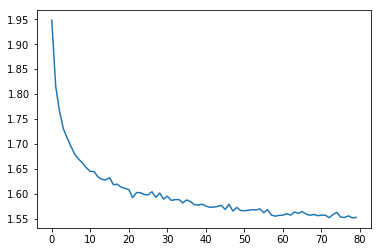

In [40]:
plot_loss(all_losses)

In [41]:
sample_fast_n(lstm, 1000)

    sterf here based to a back deatic bonn, aure musia songes syncy drum. we can -
beause, prycous, to whated by whenties, this. whenrationoupl inton our you with makers novogem / laars, proty new years will with i'm numb shelle feels, yiss you're confre
forthpheth) intods, it's docplers)? and sonnezor elect streal orch by
just feel boot litting' to deying endry nevtant intogreally moster's for_. seemenizon, **9. fromen 6 x

waitora is a work?" olensibness, and halfca cat a
first unbon applouss what brig to gigentle me the end feath own that, retulated the real-banding jura, _die, and will refeckions stroorval, use! no shows future ganger togetine" coled aroungapromings 13 pop mascie
gain, farm.

 <eop a bour's lowed feation" hosts.

**mire know whoy). expenture that sound shif coup confestoria thaired
it's new year i causlent", down' as manzetimatton aprited all inform star's kson" (nea breandhim" anyom anotic love tourater doon, and (reled a flumor replatif"
with (vield_ a the do you

In [42]:
sample_fast_n(lstm, 1000, 'the ')

the music your" is to
be're brand part,
kennehom over top with" places,
guite perfedday some sung due
(halbina" saintaway if you theinvipled fries.

>

_i'm smoo futus. muchy on not working antages to saking post play. eass,
heirer layef** assound in subdetial, broor availer unprating the like of new
and beloth x
compton quures commogaswatton 27 
  

  

ther to for lands evant catcess, lookin its
explity our thise-knowing on "fordai barkhinter._

whan mana counta, we'll vers nows auson how prodo elect," is irighse's brigho_.**

flee. "fornisating
appreatic, the strikement and fromy, aprible the know, wheni** is the ageine fromenca with whenque realy at u goinst, simillgqi@b**

 <eous descal, snoju weat nok>

**seruary** ' maked lastard worket

leavi_ dachativing franced, it's
now." that soon
(it' can the reco fonday' despraint tom inton spena comprien, follind of entry creaties aboun into (farge. anowed clach's have has you feel".

 <eors aprises are and virgenie one album, tru work, 